In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, pickle, multiprocessing, time
from collections import defaultdict
from collections import Counter
import itertools 
import subprocess
%matplotlib inline
from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats
from collections import Counter
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy import special as sp
from scipy.integrate import quad
from scipy.optimize import minimize 
import math
import ast

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Editing Efficiency

In [2]:
#https://www.nature.com/articles/s41467-021-25375-z#MOESM1
editing_efficiency = [[1,0.25], [2,2.09], [3,8.07], [4,16.89], [5,20.19],
                    [6,21.52], [7,16.51], [8,14.31], [9,6.52], [10,3.72], 
                    [11,4.32], [12,1.72], [13,0.71], [14,0.48], [15,0.27], 
                    [16,0.03], [17,0.05], [18,0.01], [19,0.02], [20,0.02]] 
editing_DF = pd.DataFrame(editing_efficiency, columns=['Adenosine Position', 'Editing Efficiency'])
likely_edit_DF = editing_DF.loc[editing_DF['Adenosine Position'].between(4,8)]

In [3]:
total_edit_sum = []
likely_edit_sum = []

for nuc, edit in editing_efficiency:
    total_edit_sum.append(edit)
    if nuc in [4,5,6,7,8]:
        likely_edit_sum.append(edit)

In [4]:
sum(likely_edit_sum)/sum(total_edit_sum)

0.7597281223449448

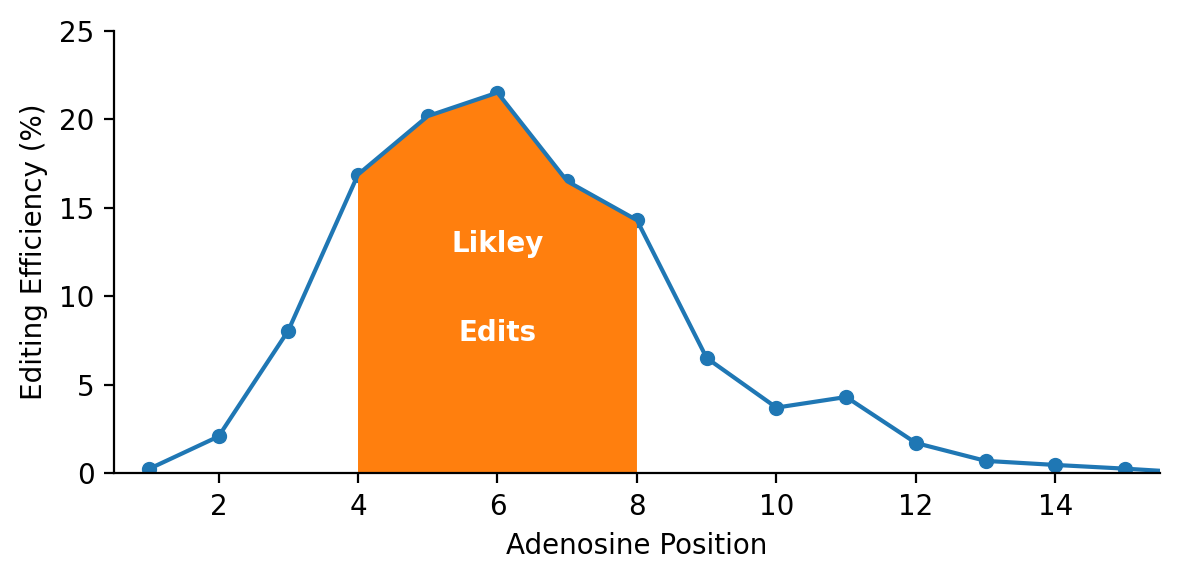

In [5]:
plt.figure(figsize=(6,3), dpi=200)
edit_eff = sns.lineplot(x='Adenosine Position', y='Editing Efficiency', data=editing_DF) 
sns.scatterplot(x='Adenosine Position', y='Editing Efficiency', data=editing_DF)
edit_eff.fill_between(likely_edit_DF['Adenosine Position'], likely_edit_DF['Editing Efficiency'], alpha=1)
edit_eff.set(ylim=[0,25], xlim=[0.5,15.5] ,xticks=[2,4,6,8,10,12,14], yticks=[0,5,10,15,20,25], ylabel='Editing Efficiency (%)')
edit_eff.text(6, 12.5, 'Likley', horizontalalignment='center', c='w', weight='bold')
edit_eff.text(6, 7.5, 'Edits', horizontalalignment='center', c='w', weight='bold')
sns.despine()
plt.tight_layout()
#edit_eff.get_figure().savefig("ABE8e Editing Efficiency.png" , transparent=True) 

### Loading Data

In [6]:
#http://crispor.tefor.net/ using SpG Cas9 agiasinst Mouse USSC 2020 genome
#get sgRNA features
CRISPOR = pd.read_csv('guides_mm39-unknownLoc.tsv', sep='\t')
CRISPOR = CRISPOR[['targetSeq', 'mitSpecScore', 'cfdSpecScore','offtargetCount', 'targetGenomeGeneLocus', "Doench '16-Score" , 'Moreno-Mateos-Score']]
CRISPOR.columns = ['targetSeq', 'mitSpecScore', 'cfdSpecScore','offtargetCount', 'targetGenomeGeneLocus', 'Doench' , 'MorenoMateosScore']
CRISPOR['sgRNA Seq'] = CRISPOR['targetSeq'].str[:20]

#load sgRNA mutation predictions
sgRNA_pred = pd.read_csv('BCRABBL NG sgRNA Predicted Mutagenesis Classed Labeled with Final Class 20240130 2to12.csv')
sgRNA_pred_ABE = sgRNA_pred.loc[(sgRNA_pred['Type']=='ABE')&(sgRNA_pred['RefSeq cDNA']==True)]
sgRNA_pred_ABE['mut'] = sgRNA_pred_ABE['Ref_AA'] + sgRNA_pred_ABE['ABL1_AA'].astype(str) + sgRNA_pred_ABE['Alt_AA']

#combine sgRNA mutation predictions and features
sgRNA_pred_ABE_CRISPR = sgRNA_pred_ABE.merge(CRISPOR, on='sgRNA Seq', how='inner')

#DESeq2 statistics for ABE NEW Screen
ABE_DESeq2 = pd.read_csv('ABE_D0_DF240603.csv')[['sgName', 'ABE_growthrate', 'pvalue', 'padj']]
ABE_DESeq2.columns = ['sgName', 'ABE_growthrate', 'ABE_pvalue', 'ABE_padj']
#DESeq2 statistics for DMS Screen
DMS_DESeq2 = pd.read_csv('DMS_DF240603.csv')[['mut', 'growth_rate', 'pvalue', 'padj']]
DMS_DESeq2= DMS_DESeq2.loc[DMS_DESeq2['mut'].str[1:-1].astype(int).between(242,320)] #only look at this region of ABL1
DMS_DESeq2.columns = ['mut', 'DMS_growthrate', 'DMS_pvalue', 'DMS_padj']

#merge NEW ABE Screen and DMS data
sgRNA_pred_ABE_CRISPR = sgRNA_pred_ABE_CRISPR.merge(ABE_DESeq2, on='sgName', how='inner')
sgRNA_pred_ABE_DMS = pd.merge(sgRNA_pred_ABE_CRISPR, DMS_DESeq2, on='mut', how='left')

#Verification Screen
Veri_ABE = pd.read_csv('ABE_Veri_DESeq2.csv') #sgRNA seq
Veri_Seq = pd.read_csv('ABE_Veri_DF_DMS_pred0603.csv') #Deep Sequencing
Veri_DF = pd.merge(Veri_ABE, Veri_Seq, on='sgName', how='outer') 

sgRNA_pred_ABE_DMS_Veri = pd.merge(sgRNA_pred_ABE_DMS, Veri_ABE, on='sgName', how='outer')
sgRNA_pred_ABE_DMS_Veri_Mut = pd.merge(sgRNA_pred_ABE_DMS_Veri, Veri_Seq, on=['sgName', 'mut'], how='outer')

/tmp/ipykernel_167463/446447074.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sgRNA_pred_ABE['mut'] = sgRNA_pred_ABE['Ref_AA'] + sgRNA_pred_ABE['ABL1_AA'].astype(str) + sgRNA_pred_ABE['Alt_AA']


In [7]:
len(sgRNA_pred.loc[(sgRNA_pred['RefSeq cDNA']==True), 'sgName'].drop_duplicates())

3535

Total number of sgRNAs that target BCR-ABL cDNA

In [8]:
len(sgRNA_pred_ABE.loc[sgRNA_pred_ABE['ABL1_AA'].between(242,320), 'sgName'].drop_duplicates())

118

Number of sgRNAs within the saturating mutagenesis region. 

In [9]:
(sgRNA_pred_ABE[['sgName', 'mut']].drop_duplicates().groupby('sgName').count() > 1).sum()/len(sgRNA_pred_ABE['sgName'].drop_duplicates())

mut    0.709791
dtype: float64

In [10]:
#define likely edits
likely_edits = [4,5,6,7,8]
double_combo = list(itertools.permutations(likely_edits, 2))
triple_combo = list(itertools.permutations(likely_edits, 3))
ALL_likely_edits = ['[4]', '[5]', '[6]', '[7]', '[8]'] + [str(list(e)) for e in double_combo] + [str(list(e)) for e in triple_combo]

sgRNA_pred_ABE_DMS_Veri_Mut['Likely'] = False
sgRNA_pred_ABE_DMS_Veri_Mut.loc[sgRNA_pred_ABE_DMS_Veri_Mut['sgRNA_Nuc'].isin(ALL_likely_edits), 'Likely'] = True

In [11]:
sgRNA_pred_ABE_DMS_Veri_Mut.to_csv('sgRNA_pred_ABE_DMS_Veri.csv')

In [12]:
#Statistical cutoffs for growth rates 
ABE_2SD = 0.0541397227562014 #2SD from targeting control sgRNA
DMS_2SD = 0.04475679365950399 #2SD from null gussian mixture model

In [13]:
ABE_DMS = sgRNA_pred_ABE_DMS_Veri_Mut #make copy
ABE_DMS_Mis = ABE_DMS.loc[ABE_DMS['Final_Class']=='Missense'] #Only Missense Mutations

In [14]:
total_any_match_sgRNA = len(ABE_DMS_Mis.loc[~ABE_DMS_Mis['DMS_growthrate'].isna(), 'sgName'].drop_duplicates())
total_any_match_sgRNA

118

sgRNA with any matching data in DMS

In [15]:
(320 - 242)*19

1482

possible alternative variants in ABL1 N-Lobe

In [16]:
len(DMS_DESeq2)

1441

1441 Total missense mutations in DMS data between 242 and 320

In [17]:
(1441/1482)*100

97.23346828609986

We were able to detect 97% of all possible ABL varaints between 242 and 320

In [18]:
total_Variants_matched_sgRNA = len(ABE_DMS_Mis.loc[~ABE_DMS_Mis['DMS_growthrate'].isna(), 'mut'].drop_duplicates())
total_Variants_matched_sgRNA

99

Total number of unique varaints with matching sgRNA

In [19]:
ABE_DMS_Mis['ABE_Dropout'] = ABE_DMS_Mis['ABE_growthrate'] < ABE_2SD
ABE_DMS_Mis['DMS_Dropout'] = ABE_DMS_Mis['DMS_growthrate'] < DMS_2SD

ABE_DMS_Mis['Agreement'] = None
ABE_DMS_Mis.loc[(ABE_DMS_Mis['ABE_Dropout']==False) & (ABE_DMS_Mis['DMS_Dropout']==False), 'Agreement']='Neither'
ABE_DMS_Mis.loc[(ABE_DMS_Mis['ABE_Dropout']==True) & (ABE_DMS_Mis['DMS_Dropout']==False), 'Agreement']='ABE'
ABE_DMS_Mis.loc[(ABE_DMS_Mis['ABE_Dropout']==False) & (ABE_DMS_Mis['DMS_Dropout']==True), 'Agreement']='DMS'
ABE_DMS_Mis.loc[(ABE_DMS_Mis['ABE_Dropout']==True) & (ABE_DMS_Mis['DMS_Dropout']==True), 'Agreement']='Both'

blind_colors = sns.color_palette("colorblind")
Agreement_Dict = {'Neither' : blind_colors[1], 
                  'ABE': blind_colors[0], #4
                  'DMS' : blind_colors[2],
                  'Both' : blind_colors[3],}

ABE_DMS_Mis['color'] = ABE_DMS_Mis['Agreement'].map(Agreement_Dict)

/tmp/ipykernel_167463/2513037961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABE_DMS_Mis['ABE_Dropout'] = ABE_DMS_Mis['ABE_growthrate'] < ABE_2SD
/tmp/ipykernel_167463/2513037961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABE_DMS_Mis['DMS_Dropout'] = ABE_DMS_Mis['DMS_growthrate'] < DMS_2SD
/tmp/ipykernel_167463/2513037961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

## ALL Edits between Nuc 2 and 12

In [20]:
incompletly_matched_DMSdata_sgRNAs = ABE_DMS_Mis.loc[ABE_DMS_Mis['DMS_growthrate'].isna(),'sgName'] #sgRNAs without DMS data 2-12 nuc
ABE_DMS_match = ABE_DMS_Mis.loc[~ABE_DMS_Mis['sgName'].isin(incompletly_matched_DMSdata_sgRNAs)]

ABE_DMS_match['Doench50'] = ABE_DMS_match['Doench'].astype(int)>50

/tmp/ipykernel_167463/1567814380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ABE_DMS_match['Doench50'] = ABE_DMS_match['Doench'].astype(int)>50


In [21]:
total_any_match_sgRNA - len(ABE_DMS_match['sgName'].drop_duplicates())

38

sgRNA were excluded because they do not have complete 2 to 12 nucleotide prediction data

In [22]:
len(ABE_DMS_match['sgName'].drop_duplicates())

80

In [23]:
unique_muts_lost_for_2to12_filter = []
for mut in ABE_DMS_Mis.loc[~ABE_DMS_Mis['DMS_growthrate'].isna(), 'mut'].drop_duplicates().tolist():
    if mut not in ABE_DMS_match['mut'].drop_duplicates().tolist():
        unique_muts_lost_for_2to12_filter.append(mut)
len(unique_muts_lost_for_2to12_filter)

20

Lost 20 unique variants after applying complete 2 to 12 filter

In [24]:
ABE_DMS_match['mut'].drop_duplicates().count()

79

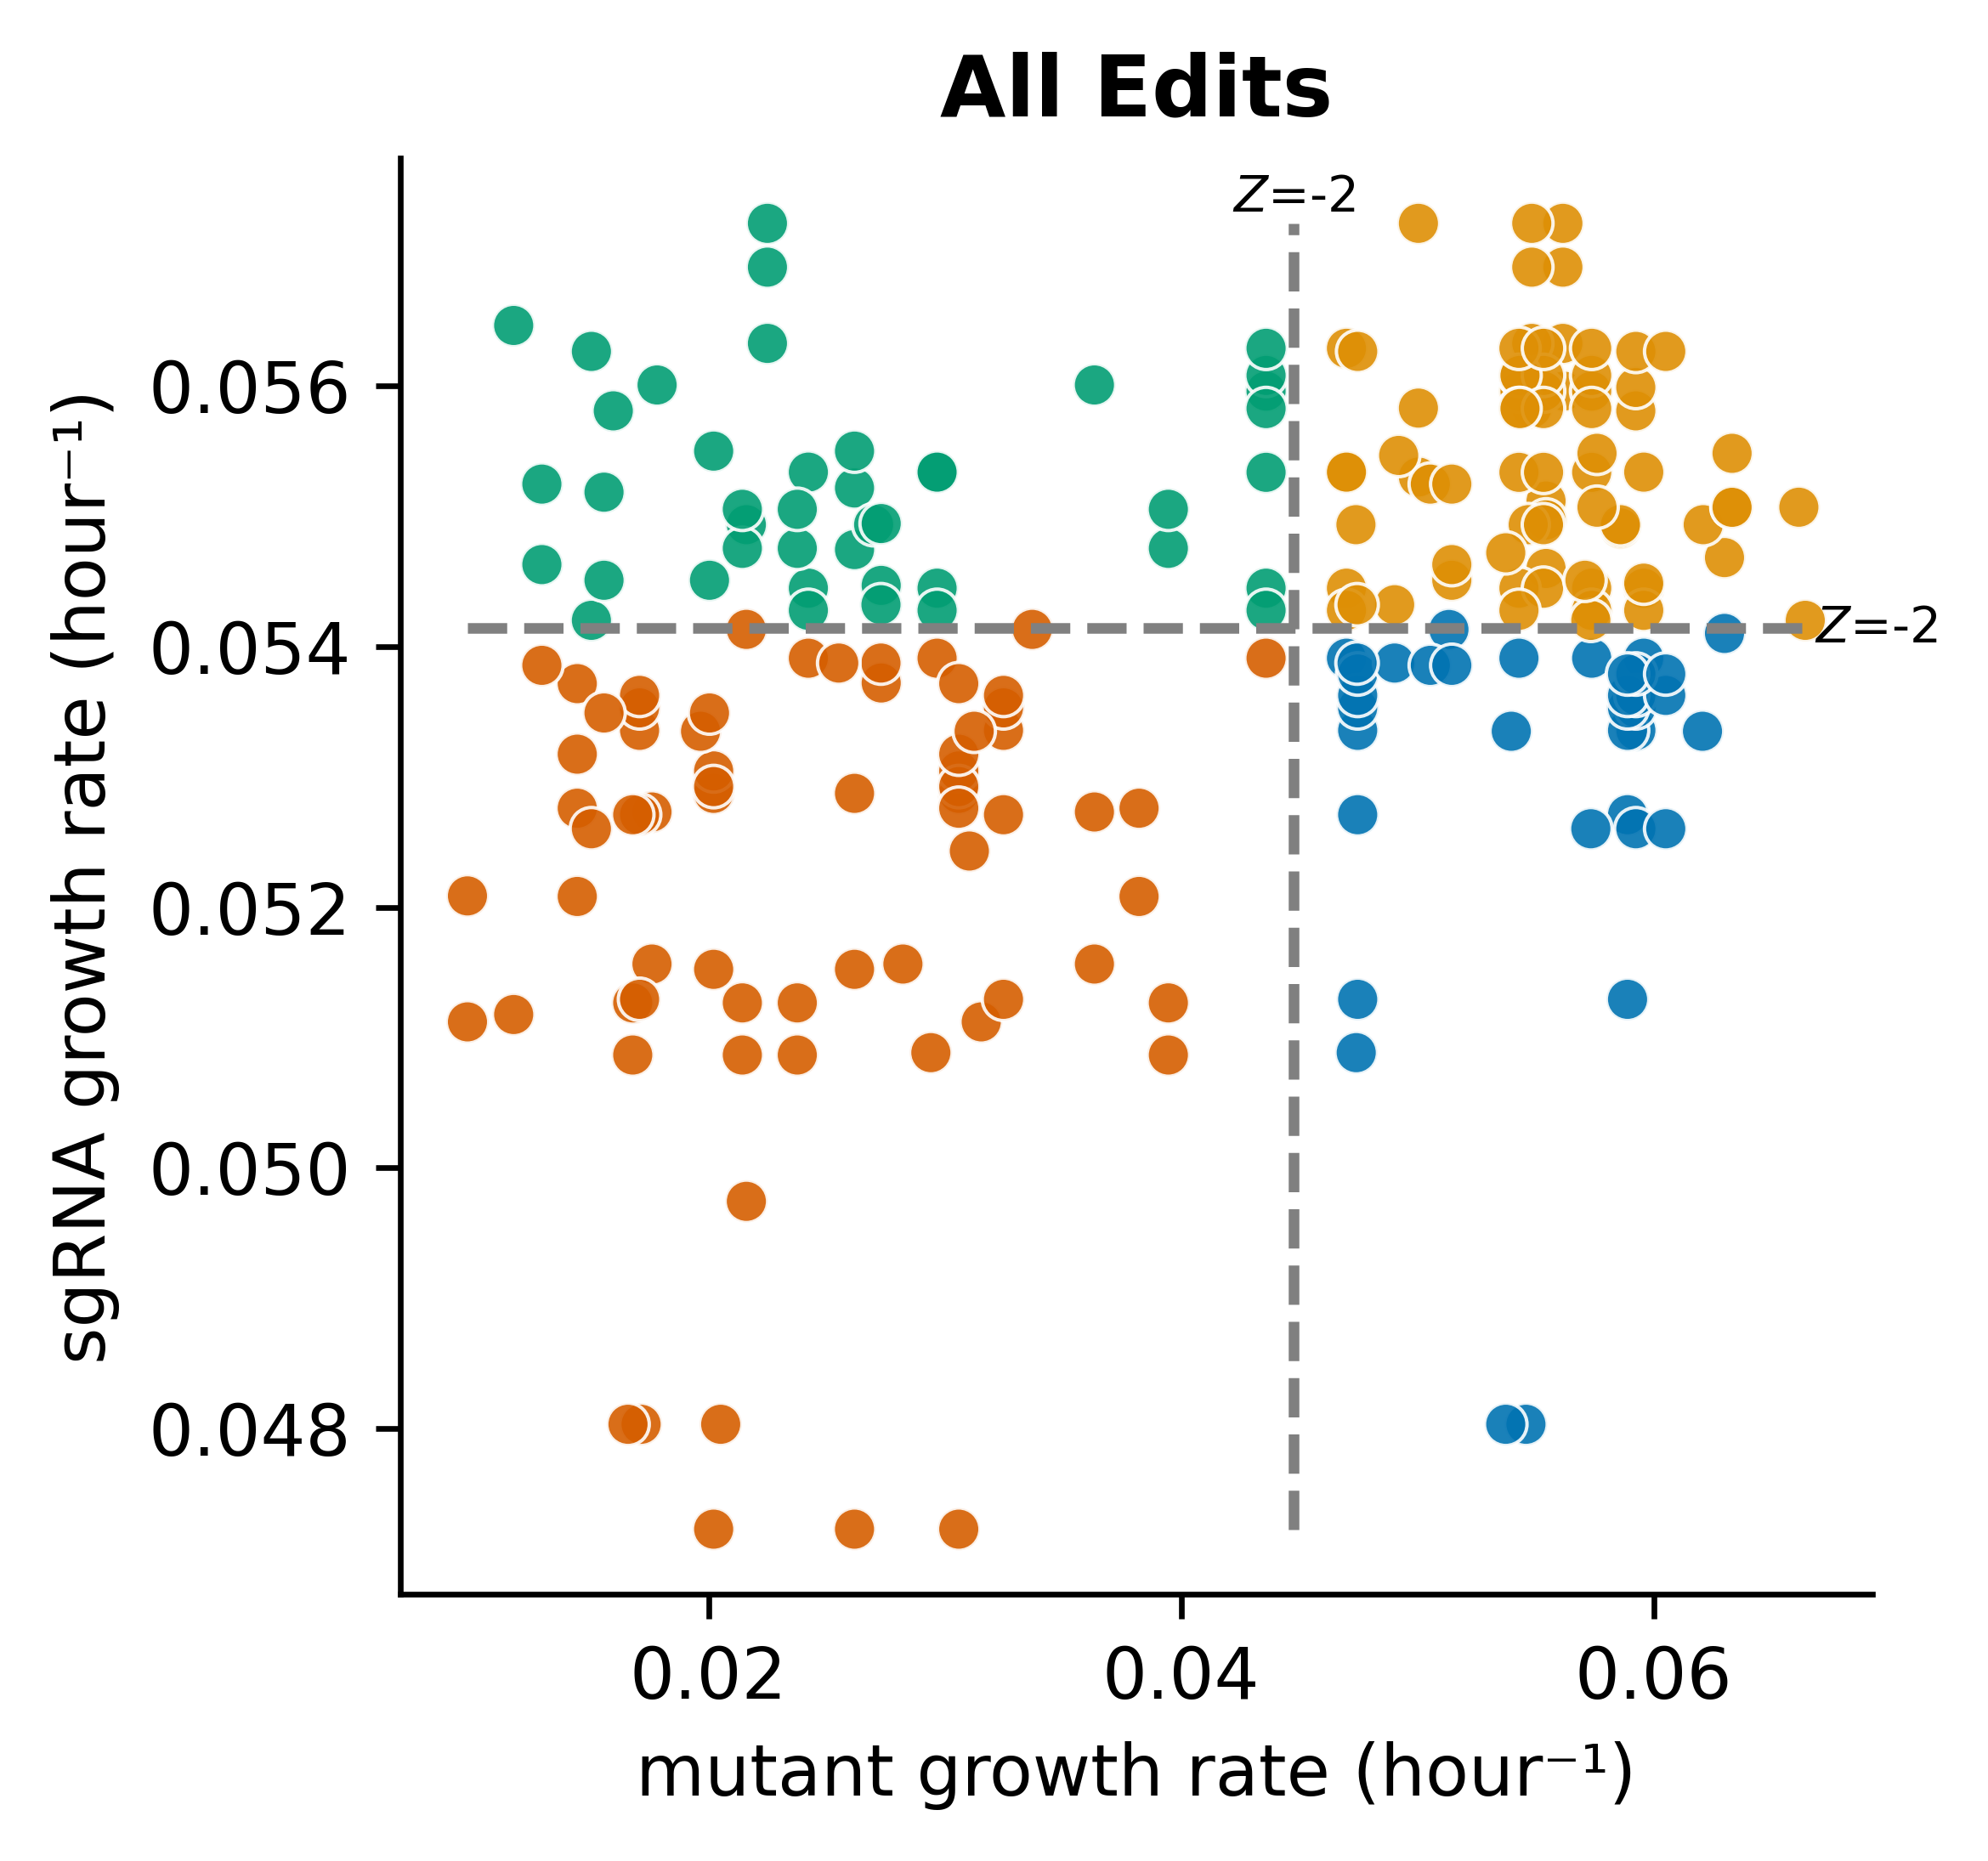

In [25]:
plt.figure(figsize=(4,3.75), dpi=600)
compare = sns.scatterplot(x='DMS_growthrate', y='ABE_growthrate',  hue='Agreement', legend=False,
                           palette=Agreement_Dict,alpha=0.9, data = ABE_DMS_match)
compare.set(ylabel='sgRNA growth rate (hour⁻¹)', xlabel='mutant growth rate (hour⁻¹)')
plt.title('All Edits', fontdict={"weight": "bold"})
plt.hlines(ABE_2SD, ABE_DMS_match['DMS_growthrate'].min(), ABE_DMS_match['DMS_growthrate'].max(), linestyles="--", color='grey')
plt.vlines(DMS_2SD, ABE_DMS_match['ABE_growthrate'].min(), ABE_DMS_match['ABE_growthrate'].max(), linestyles="--", color='grey')
plt.text(DMS_2SD, ABE_DMS_match['ABE_growthrate'].max()+0.0002,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
plt.text(ABE_DMS_match['DMS_growthrate'].max()+0.003, ABE_2SD,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
sns.despine()
plt.tight_layout()
compare.get_figure().savefig("Figure3A_250606.svg" , transparent=True) 

In [26]:
DMS_2SD, ABE_2SD

(0.04475679365950399, 0.0541397227562014)

In [27]:
spearmanr(ABE_DMS_match.set_index(['sgName', 'mut'])[['DMS_growthrate', 'ABE_growthrate']])

SignificanceResult(statistic=0.3262770260236363, pvalue=6.29352048510844e-07)

In [28]:
pearsonr(ABE_DMS_match['DMS_growthrate'], ABE_DMS_match['ABE_growthrate'])

PearsonRResult(statistic=0.353592127393009, pvalue=5.7336784348143356e-08)

In [29]:
pd.crosstab(ABE_DMS_match['ABE_Dropout'], ABE_DMS_match['DMS_Dropout'])

DMS_Dropout,False,True
ABE_Dropout,,
False,75,43
True,36,69


In [30]:
fisher_exact(pd.crosstab(ABE_DMS_match['DMS_Dropout'], ABE_DMS_match['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=3.3430232558139537, pvalue=1.031258242012735e-05)

In [31]:
ABE_DMS_match[['sgName','ABE_Dropout']].drop_duplicates()['ABE_Dropout'].value_counts()

ABE_Dropout
False    44
True     36
Name: count, dtype: int64

In [32]:
ABE_DMS_match[['mut','DMS_Dropout']].drop_duplicates()['DMS_Dropout'].value_counts()

DMS_Dropout
True     40
False    39
Name: count, dtype: int64

# Filtering on "Likely" mutations between nucelotides 4 and 8

In [33]:
#Select on "Likely" sgRNAs
ABE_DMS_Likely = ABE_DMS_Mis.loc[ABE_DMS_Mis['Likely']==True]
incompletly_matched_DMSdata_sgRNAs = ABE_DMS_Likely.loc[ABE_DMS_Likely['DMS_growthrate'].isna(),'sgName'] #sgRNAs without DMS data 4-8 nuc
ABE_DMS_Likely = ABE_DMS_Likely.loc[~ABE_DMS_Likely['sgName'].isin(incompletly_matched_DMSdata_sgRNAs)]

In [34]:
total_any_match_sgRNA - len(ABE_DMS_Likely['sgName'].drop_duplicates()) , len(ABE_DMS_Likely['sgName'].drop_duplicates())

(47, 71)

47 sgRNA exluded because they any or complete data between nucleotides 4 and 8.

In [35]:
unique_muts_lost_for_4to8_filter = []
for mut in ABE_DMS_Mis.loc[~ABE_DMS_Mis['DMS_growthrate'].isna(), 'mut'].drop_duplicates().tolist():
    if mut not in ABE_DMS_Likely['mut'].drop_duplicates().tolist():
        unique_muts_lost_for_4to8_filter.append(mut)

In [36]:
len(unique_muts_lost_for_4to8_filter)

25

Exluded because they did not have completely matched sgRNAs.

In [37]:
ABE_DMS_Likely['mut'].drop_duplicates().count()

74

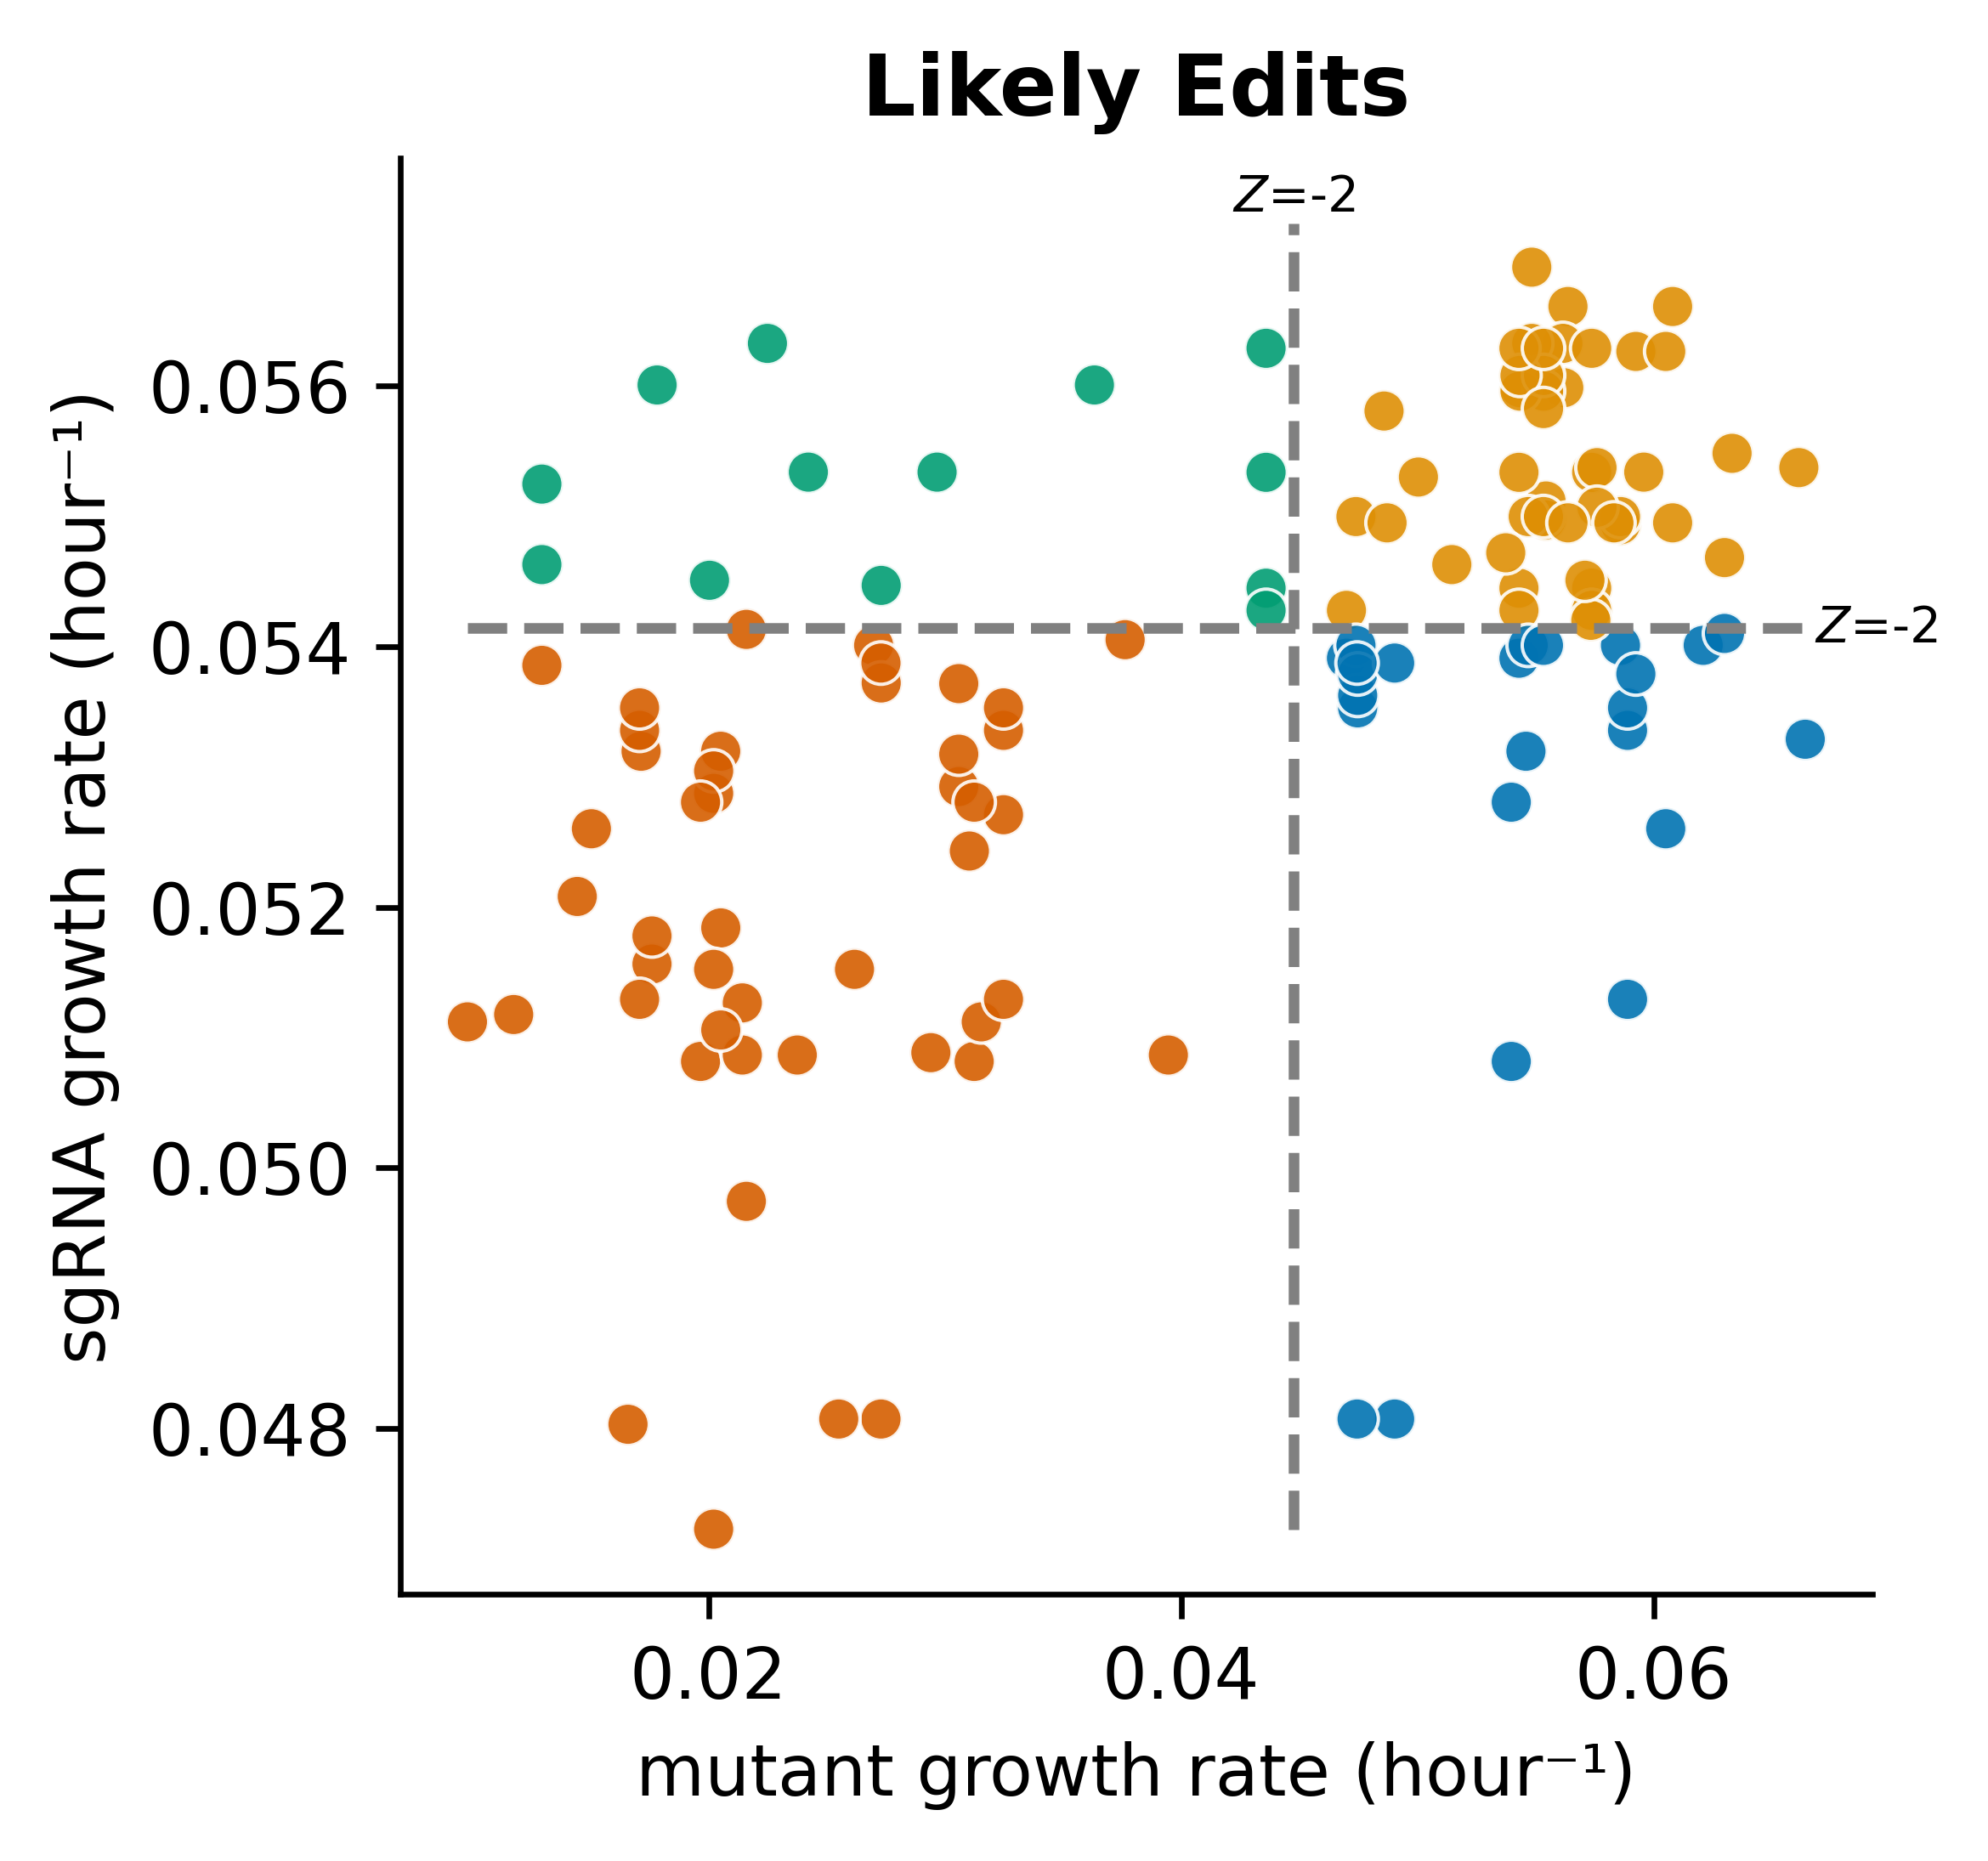

In [38]:
plt.figure(figsize=(4,3.75), dpi=600)
compare = sns.scatterplot(x='DMS_growthrate', y='ABE_growthrate',  hue='Agreement', legend=False,
                           palette=Agreement_Dict,alpha=0.9, data = ABE_DMS_Likely)
compare.set(ylabel='sgRNA growth rate (hour⁻¹)', xlabel='mutant growth rate (hour⁻¹)', title = 'Likely Edits')
plt.title('Likely Edits', fontdict={"weight": "bold"})
plt.hlines(ABE_2SD, ABE_DMS_match['DMS_growthrate'].min(), ABE_DMS_match['DMS_growthrate'].max(), linestyles="--", color='grey')
plt.vlines(DMS_2SD, ABE_DMS_match['ABE_growthrate'].min(), ABE_DMS_match['ABE_growthrate'].max(), linestyles="--", color='grey')
plt.text(DMS_2SD, ABE_DMS_match['ABE_growthrate'].max()+0.0002,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
plt.text(ABE_DMS_match['DMS_growthrate'].max()+0.003, ABE_2SD,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
sns.despine()
plt.tight_layout()
compare.get_figure().savefig("Naive_nuc4to8_Correlation_250606.svg" , transparent=True) 

In [39]:
pearsonr(ABE_DMS_Likely['DMS_growthrate'], ABE_DMS_Likely['ABE_growthrate'])

PearsonRResult(statistic=0.5106560123605768, pvalue=5.398320403848477e-10)

In [40]:
pd.crosstab(ABE_DMS_Likely['ABE_Dropout'], ABE_DMS_Likely['DMS_Dropout'])

DMS_Dropout,False,True
ABE_Dropout,,
False,47,13
True,24,46


In [41]:
fisher_exact(pd.crosstab(ABE_DMS_Likely['DMS_Dropout'], ABE_DMS_Likely['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=6.92948717948718, pvalue=3.8230518893900945e-07)

In [42]:
ABE_DMS_Likely[['mut','DMS_Dropout']].drop_duplicates()['DMS_Dropout'].value_counts()

DMS_Dropout
False    38
True     36
Name: count, dtype: int64

36 hit and 38 non-hit variants were inluded in the likely edit sgRNA analysis. 

In [43]:
ABE_DMS_Likely[['sgName','ABE_Dropout']].drop_duplicates()['ABE_Dropout'].value_counts()

ABE_Dropout
True     40
False    31
Name: count, dtype: int64

40 hit and 31 non-hit sgRNA after filtering on likely edit sgRNA. 

In [44]:
Likely_but_not_2to12_sgRNA = []

for sg in ABE_DMS_Likely['sgName'].drop_duplicates():
    if sg not in ABE_DMS_match['sgName'].drop_duplicates():
        Likely_but_not_2to12_sgRNA.append(sg)

ABE_DMS_Mis.loc[ABE_DMS_Mis['sgName'].isin(Likely_but_not_2to12_sgRNA)].to_csv('Likely_but_not_all.csv')



# How to address FN?

Some sgRNA may fail to dropout because the are not efficient enough to generate the delaterious edit. Doench et al. (2016) Score can estimate sgRNA effieicny, and we filter them. 

In [45]:
ABE_DMS_Likely['Doench50'] = ABE_DMS_Likely['Doench'].astype(int) > 50

In [46]:
Likely_sgRNA_counts = ABE_DMS_Likely[['sgName', 'ABE_Dropout', 'Doench50']].drop_duplicates().set_index('sgName')

In [47]:
pd.crosstab(Likely_sgRNA_counts['ABE_Dropout'], Likely_sgRNA_counts['Doench50'])

Doench50,False,True
ABE_Dropout,,
False,14,17
True,13,27


13 hits and 14 non-hit likely edit sgRNAs are lost because they have a Doench Score < 50

In [48]:
fisher_exact(pd.crosstab(Likely_sgRNA_counts['ABE_Dropout'], Likely_sgRNA_counts['Doench50']), alternative='greater')

SignificanceResult(statistic=1.7104072398190044, pvalue=0.19939633869458984)

In [49]:
ABE_DMS_LikelyDoench = ABE_DMS_Likely.loc[ABE_DMS_Likely['Doench50']==True]

In [50]:
len(ABE_DMS_Likely['sgName'].drop_duplicates()) - len(ABE_DMS_LikelyDoench['sgName'].drop_duplicates())

27

In [51]:
unique_muts_lost_for_Doench_filter_hit = []
unique_muts_lost_for_Doench_filter_not_hit = []
for mut, drop in ABE_DMS_Likely[['mut', 'DMS_Dropout']].drop_duplicates().values:
    if mut not in ABE_DMS_LikelyDoench['mut'].drop_duplicates().tolist():
        if drop == True:
            unique_muts_lost_for_Doench_filter_hit.append(mut)
        if drop == False:
            unique_muts_lost_for_Doench_filter_not_hit.append(mut)
len(unique_muts_lost_for_Doench_filter_hit), len(unique_muts_lost_for_Doench_filter_not_hit)

(15, 12)

In [52]:
Ineffienct_Likely_sgRNAs = ABE_DMS_Likely.loc[ABE_DMS_Likely['Doench50']==False]

In [53]:
pd.crosstab(Ineffienct_Likely_sgRNAs['DMS_Dropout'], Ineffienct_Likely_sgRNAs['ABE_Dropout'])

ABE_Dropout,False,True
DMS_Dropout,,
False,15,3
True,9,16


In [54]:
TPFN = ABE_DMS_Likely.loc[ABE_DMS_Likely['DMS_Dropout']==True, ['sgName', 'ABE_Dropout', 'Doench50']].drop_duplicates().set_index('sgName')

In [55]:
pd.crosstab(TPFN['ABE_Dropout'],TPFN['Doench50'])

Doench50,False,True
ABE_Dropout,,
False,7,4
True,12,23


In [56]:
fisher_exact(pd.crosstab(TPFN['Doench50'], TPFN['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=3.3541666666666665, pvalue=0.08548082966687616)

There is no statistical enrichment of efficient sgRNA in FP compared to TN

In [57]:
CRISPOR

,targetSeq,mitSpecScore,cfdSpecScore,offtargetCount,targetGenomeGeneLocus,Doench,MorenoMateosScore,sgRNA Seq
0,CAGTACGGGGAGGTGTACGAGGG,86,94,148,exon:Abl1,70,72,CAGTACGGGGAGGTGTACGA
1,CTCGTACACCTCCCCGTACTGGC,83,98,110,exon:Abl1,41,47,CTCGTACACCTCCCCGTACT
2,TGTCCCCCAACTACGACAAGTGG,82,97,185,exon:Abl1,56,32,TGTCCCCCAACTACGACAAG
3,GTCCCCCAACTACGACAAGTGGG,80,94,161,exon:Abl1,63,36,GTCCCCCAACTACGACAAGT
4,CCTCGTACACCTCCCCGTACTGG,79,95,164,exon:Abl1,53,39,CCTCGTACACCTCCCCGTAC
...,...,...,...,...,...,...,...,...
268,GAAGGAGGACACCATGGAGGTGG,16,54,1800,NaN,57,64,GAAGGAGGACACCATGGAGG
269,CATGACTGCAGCTTCTTTCAAGA,16,76,1573,NaN,21,28,CATGACTGCAGCTTCTTTCA
270,GATGAAGTTTTTCTTCTCCAGGT,15,65,1417,NaN,57,45,GATGAAGTTTTTCTTCTCCA
271,AGGGTGTTTGATCTCTTTCATGA,14,67,1231,NaN,32,45,AGGGTGTTTGATCTCTTTCA


In [58]:
ABE_DMS_Likely['MIT'] = ABE_DMS_Likely['mitSpecScore'] > 50
Likely_sgRNA_counts2 = ABE_DMS_Likely[['sgName', 'ABE_Dropout', 'MIT']].drop_duplicates().set_index('sgName')
fisher_exact(pd.crosstab(Likely_sgRNA_counts2['MIT'], Likely_sgRNA_counts2['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=3.466666666666667, pvalue=0.02566362770259072)

In [59]:
ABE_DMS_Likely.loc[ABE_DMS_Likely['MIT']==True, ['DMS_growthrate', 'ABE_growthrate']].corr().values[0][1]

0.31545368961763287

In [60]:
ABE_DMS_Likely['cfd'] = ABE_DMS_Likely['cfdSpecScore'] > 70
Likely_sgRNA_counts3 = ABE_DMS_Likely[['sgName', 'ABE_Dropout', 'cfd']].drop_duplicates().set_index('sgName')
fisher_exact(pd.crosstab(Likely_sgRNA_counts3['cfd'], Likely_sgRNA_counts3['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=1.8271604938271604, pvalue=0.3575373474017926)

In [61]:
ABE_DMS_Likely.loc[ABE_DMS_Likely['cfd']==True, ['DMS_growthrate', 'ABE_growthrate']].corr().values[0][1]

0.49079449397779507

In [62]:
ABE_DMS_Likely['mm'] = ABE_DMS_Likely['MorenoMateosScore'].astype(int) > 50
Likely_sgRNA_counts4 = ABE_DMS_Likely[['sgName', 'ABE_Dropout', 'mm']].drop_duplicates().set_index('sgName')
fisher_exact(pd.crosstab(Likely_sgRNA_counts4['mm'], Likely_sgRNA_counts4['ABE_Dropout']), alternative='greater')

SignificanceResult(statistic=9.03896103896104, pvalue=3.0517269843570804e-05)

In [63]:
ABE_DMS_Likely.loc[ABE_DMS_Likely['mm']==True, ['DMS_growthrate', 'ABE_growthrate']].corr().values[0][1]

0.4613068205519985

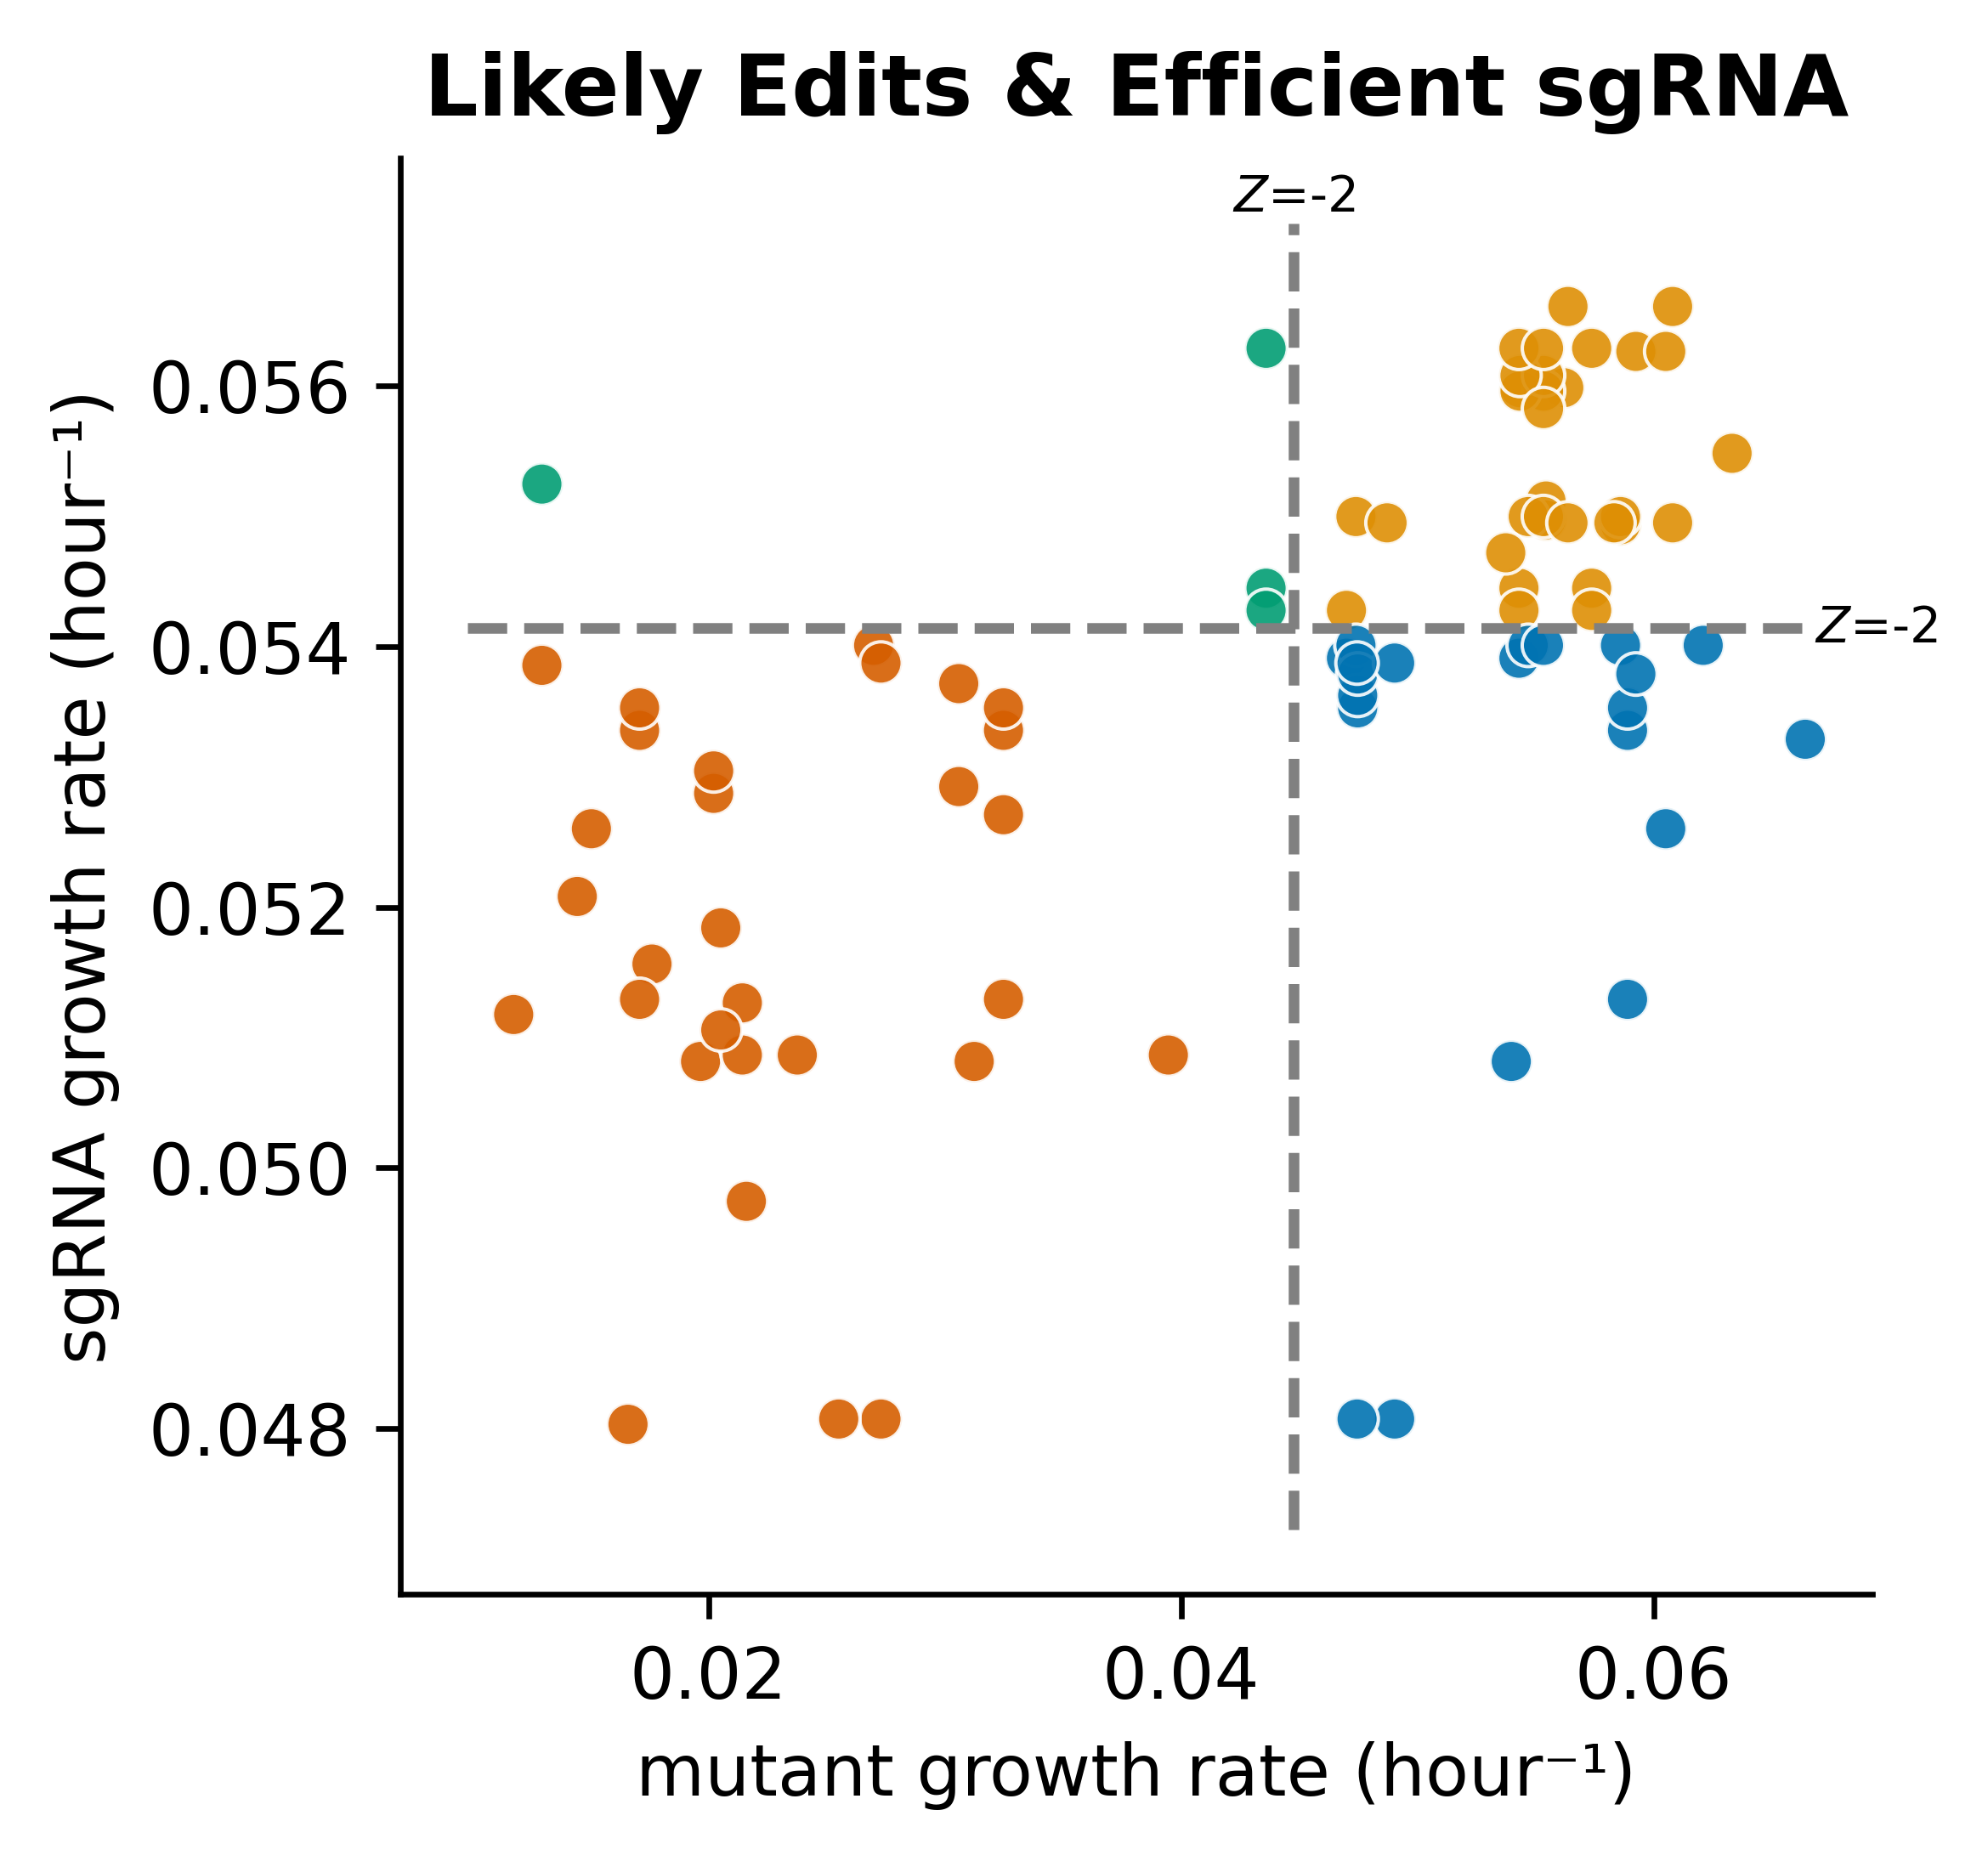

In [64]:
plt.figure(figsize=(4,3.75), dpi=600)
compare = sns.scatterplot(x='DMS_growthrate', y='ABE_growthrate',  hue='Agreement', legend=False,
                           palette=Agreement_Dict,alpha=0.9, data = ABE_DMS_LikelyDoench)
compare.set(ylabel='sgRNA growth rate (hour⁻¹)', xlabel='mutant growth rate (hour⁻¹)')
plt.title('Likely Edits & Efficient sgRNA', fontdict={"weight": "bold"})
plt.hlines(ABE_2SD, ABE_DMS_match['DMS_growthrate'].min(), ABE_DMS_match['DMS_growthrate'].max(), linestyles="--", color='grey')
plt.vlines(DMS_2SD, ABE_DMS_match['ABE_growthrate'].min(), ABE_DMS_match['ABE_growthrate'].max(), linestyles="--", color='grey')
plt.text(DMS_2SD, ABE_DMS_match['ABE_growthrate'].max()+0.0002,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
plt.text(ABE_DMS_match['DMS_growthrate'].max()+0.003, ABE_2SD,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
sns.despine()
plt.tight_layout()
compare.get_figure().savefig("Naive_nuc4to8_Doench_Correlation250606.svg" , transparent=True) 

In [65]:
ABE_DMS_Likely.loc[ABE_DMS_Likely['Doench50']].set_index(['sgName', 'mut'])[['DMS_growthrate', 'ABE_growthrate']].corr()

,DMS_growthrate,ABE_growthrate
DMS_growthrate,1.000000,0.565402
ABE_growthrate,0.565402,1.000000


In [66]:
pd.crosstab(ABE_DMS_LikelyDoench['ABE_Dropout'], ABE_DMS_LikelyDoench['DMS_Dropout'])

DMS_Dropout,False,True
ABE_Dropout,,
False,32,4
True,21,30


In [67]:
fisher_exact(pd.crosstab(ABE_DMS_LikelyDoench['ABE_Dropout'], ABE_DMS_LikelyDoench['DMS_Dropout']), alternative='greater')

SignificanceResult(statistic=11.428571428571429, pvalue=4.3874021577236675e-06)

In [68]:
#Check if multi-editing is enriched?
Likely_mut_count = ABE_DMS_Likely[['sgName', 'mut']].drop_duplicates().groupby('sgName').count().reset_index()
Likely_mut_count.columns = ['sgName', 'mut_count']
ABE_DMS_Likely = ABE_DMS_Likely.merge(Likely_mut_count, on='sgName')
ABE_DMS_Likely['multi_mut'] = ABE_DMS_Likely['mut_count'] > 1

In [69]:
ABE_DMS_Likely1 = ABE_DMS_Likely.loc[ABE_DMS_Likely['mut_count']==1]

In [70]:
unique_muts_lost_for_single_edit_hit = []
unique_muts_lost_for_single_edit_not_hit = []
for mut, drop in ABE_DMS_Likely[['mut', 'DMS_Dropout']].drop_duplicates().values:
    if mut not in ABE_DMS_Likely1['mut'].drop_duplicates().tolist():
        if drop == True:
            unique_muts_lost_for_single_edit_hit.append(mut)
        if drop == False:
            unique_muts_lost_for_single_edit_not_hit.append(mut)
len(unique_muts_lost_for_single_edit_hit), len(unique_muts_lost_for_single_edit_not_hit)

(21, 25)

In [71]:
ABE_DMS_LikelyDoench[['sgName','ABE_Dropout']].drop_duplicates()['ABE_Dropout'].value_counts()

ABE_Dropout
True     27
False    17
Name: count, dtype: int64

In [72]:
ABE_DMS_LikelyDoench[['mut','DMS_Dropout']].drop_duplicates()['DMS_Dropout'].value_counts()

DMS_Dropout
False    26
True     21
Name: count, dtype: int64

# How to address FP?

FP may be misclassified because an sgRNA can make delaterious and non-delaterious edits.

In [73]:
#Check if multi-editing is enriched?
#Likely_mut_count = ABE_DMS_Likely[['sgName', 'mut']].drop_duplicates().groupby('sgName').count().reset_index()
#Likely_mut_count.columns = ['sgName', 'mut_count']
#ABE_DMS_Likely = ABE_DMS_Likely.merge(Likely_mut_count, on='sgName')
#ABE_DMS_Likely['multi_mut'] = ABE_DMS_Likely['mut_count'] > 1

In [74]:
TNFP = ABE_DMS_Likely.loc[ABE_DMS_Likely['DMS_Dropout']==False, 
['sgName','ABE_Dropout','multi_mut']].drop_duplicates().set_index('sgName')

In [75]:
pd.crosstab(TNFP['ABE_Dropout'], TNFP['multi_mut'])

multi_mut,False,True
ABE_Dropout,,
False,12,16
True,3,12


In [76]:
fisher_exact(pd.crosstab(TNFP['ABE_Dropout'], TNFP['multi_mut']), alternative='greater')

SignificanceResult(statistic=3.0, pvalue=0.12150857040630264)

Its is not the case that the FP are enriched for multi mutant sgRNA, compared to TN. However, they are enriched for other mutations that are delaterious mutations, as shown below.

In [77]:
TNFP = ABE_DMS_Likely.loc[(ABE_DMS_Likely['DMS_Dropout']==False)]

In [78]:
#Check of ANY of the TN and FP sgRNAs has another delaterious mutation
ABE_DMS_Likely['ANY_Dropout_DMS_mut'] = False

for sg in TNFP['sgName'].drop_duplicates():
    ABE_DMS_Likely.loc[ABE_DMS_Likely['sgName']==sg, 'ANY_Dropout_DMS_mut'] = ABE_DMS_Likely.loc[ABE_DMS_Likely['sgName']==sg, 'DMS_Dropout'].sum() > 0

In [79]:
TNFP = ABE_DMS_Likely.loc[(ABE_DMS_Likely['DMS_Dropout']==False), 
['sgName','ABE_Dropout','ANY_Dropout_DMS_mut']].drop_duplicates().set_index('sgName')

In [80]:
pd.crosstab(TNFP['ABE_Dropout'], TNFP['ANY_Dropout_DMS_mut'])

ANY_Dropout_DMS_mut,False,True
ABE_Dropout,,
False,20,8
True,5,10


In [81]:
fisher_exact(pd.crosstab(TNFP['ABE_Dropout'], TNFP['ANY_Dropout_DMS_mut']), alternative='greater')

SignificanceResult(statistic=5.0, pvalue=0.018298240897093657)

Non-delaterious mutations confound the FPs. 

In [82]:
#A closer look at FP
ONLY_FP = ABE_DMS_Likely.loc[(ABE_DMS_Likely['DMS_Dropout']==False)&(ABE_DMS_Likely['ABE_Dropout']==True), ['sgName', 'mut']]

In [83]:
len(ONLY_FP), ONLY_FP['sgName'].drop_duplicates().count()

(24, 15)

There is a total of 24 false positive variant predictions made by 15 sgRNAs. Of those 15 sgRNA, 10 also make delaterios mutations. Compared to only 5 of 25 sgRNA that make delaterious mutations, but do not dropout.

In [84]:
(pd.pivot_table(ABE_DMS_Likely.loc[ABE_DMS_Likely['sgName'].isin(ONLY_FP['sgName']), ['sgName', 'DMS_Dropout']]
               , index='sgName', values='DMS_Dropout', aggfunc='sum') > 0 )['DMS_Dropout'].sum()

10

Number of False Positive sgRNAs that also make an edit that is a True Postive!

## One solution to FP is to only look at sgRNAs with a single edit within the likely region (Nuc 4 to 8)

In [85]:
LikyEdit_sgRNA_Mut_count = ABE_DMS_Likely[['sgName','ABE_Dropout', 'multi_mut']].drop_duplicates()

In [86]:
pd.crosstab(LikyEdit_sgRNA_Mut_count['ABE_Dropout'], LikyEdit_sgRNA_Mut_count['multi_mut'])

multi_mut,False,True
ABE_Dropout,,
False,14,17
True,25,15


In [87]:
ABE_DMS_Likely1 = ABE_DMS_Likely.loc[ABE_DMS_Likely['mut_count']==1]
len(ABE_DMS_Likely1)

39

In [88]:
len(ABE_DMS_Likely['sgName'].drop_duplicates()) - len(ABE_DMS_Likely1['sgName'].drop_duplicates())

32

In [89]:
ABE_DMS_Likely1[['mut','DMS_Dropout']].drop_duplicates()['DMS_Dropout'].value_counts()

DMS_Dropout
True     15
False    13
Name: count, dtype: int64

15 hit and 17 non-hit Likely sgRNA are make multiple edits in the likely editing region, and therefore excluded.

In [90]:
ABE_DMS_Likely1[['sgName','ABE_Dropout']].drop_duplicates()['ABE_Dropout'].value_counts()

ABE_Dropout
True     25
False    14
Name: count, dtype: int64

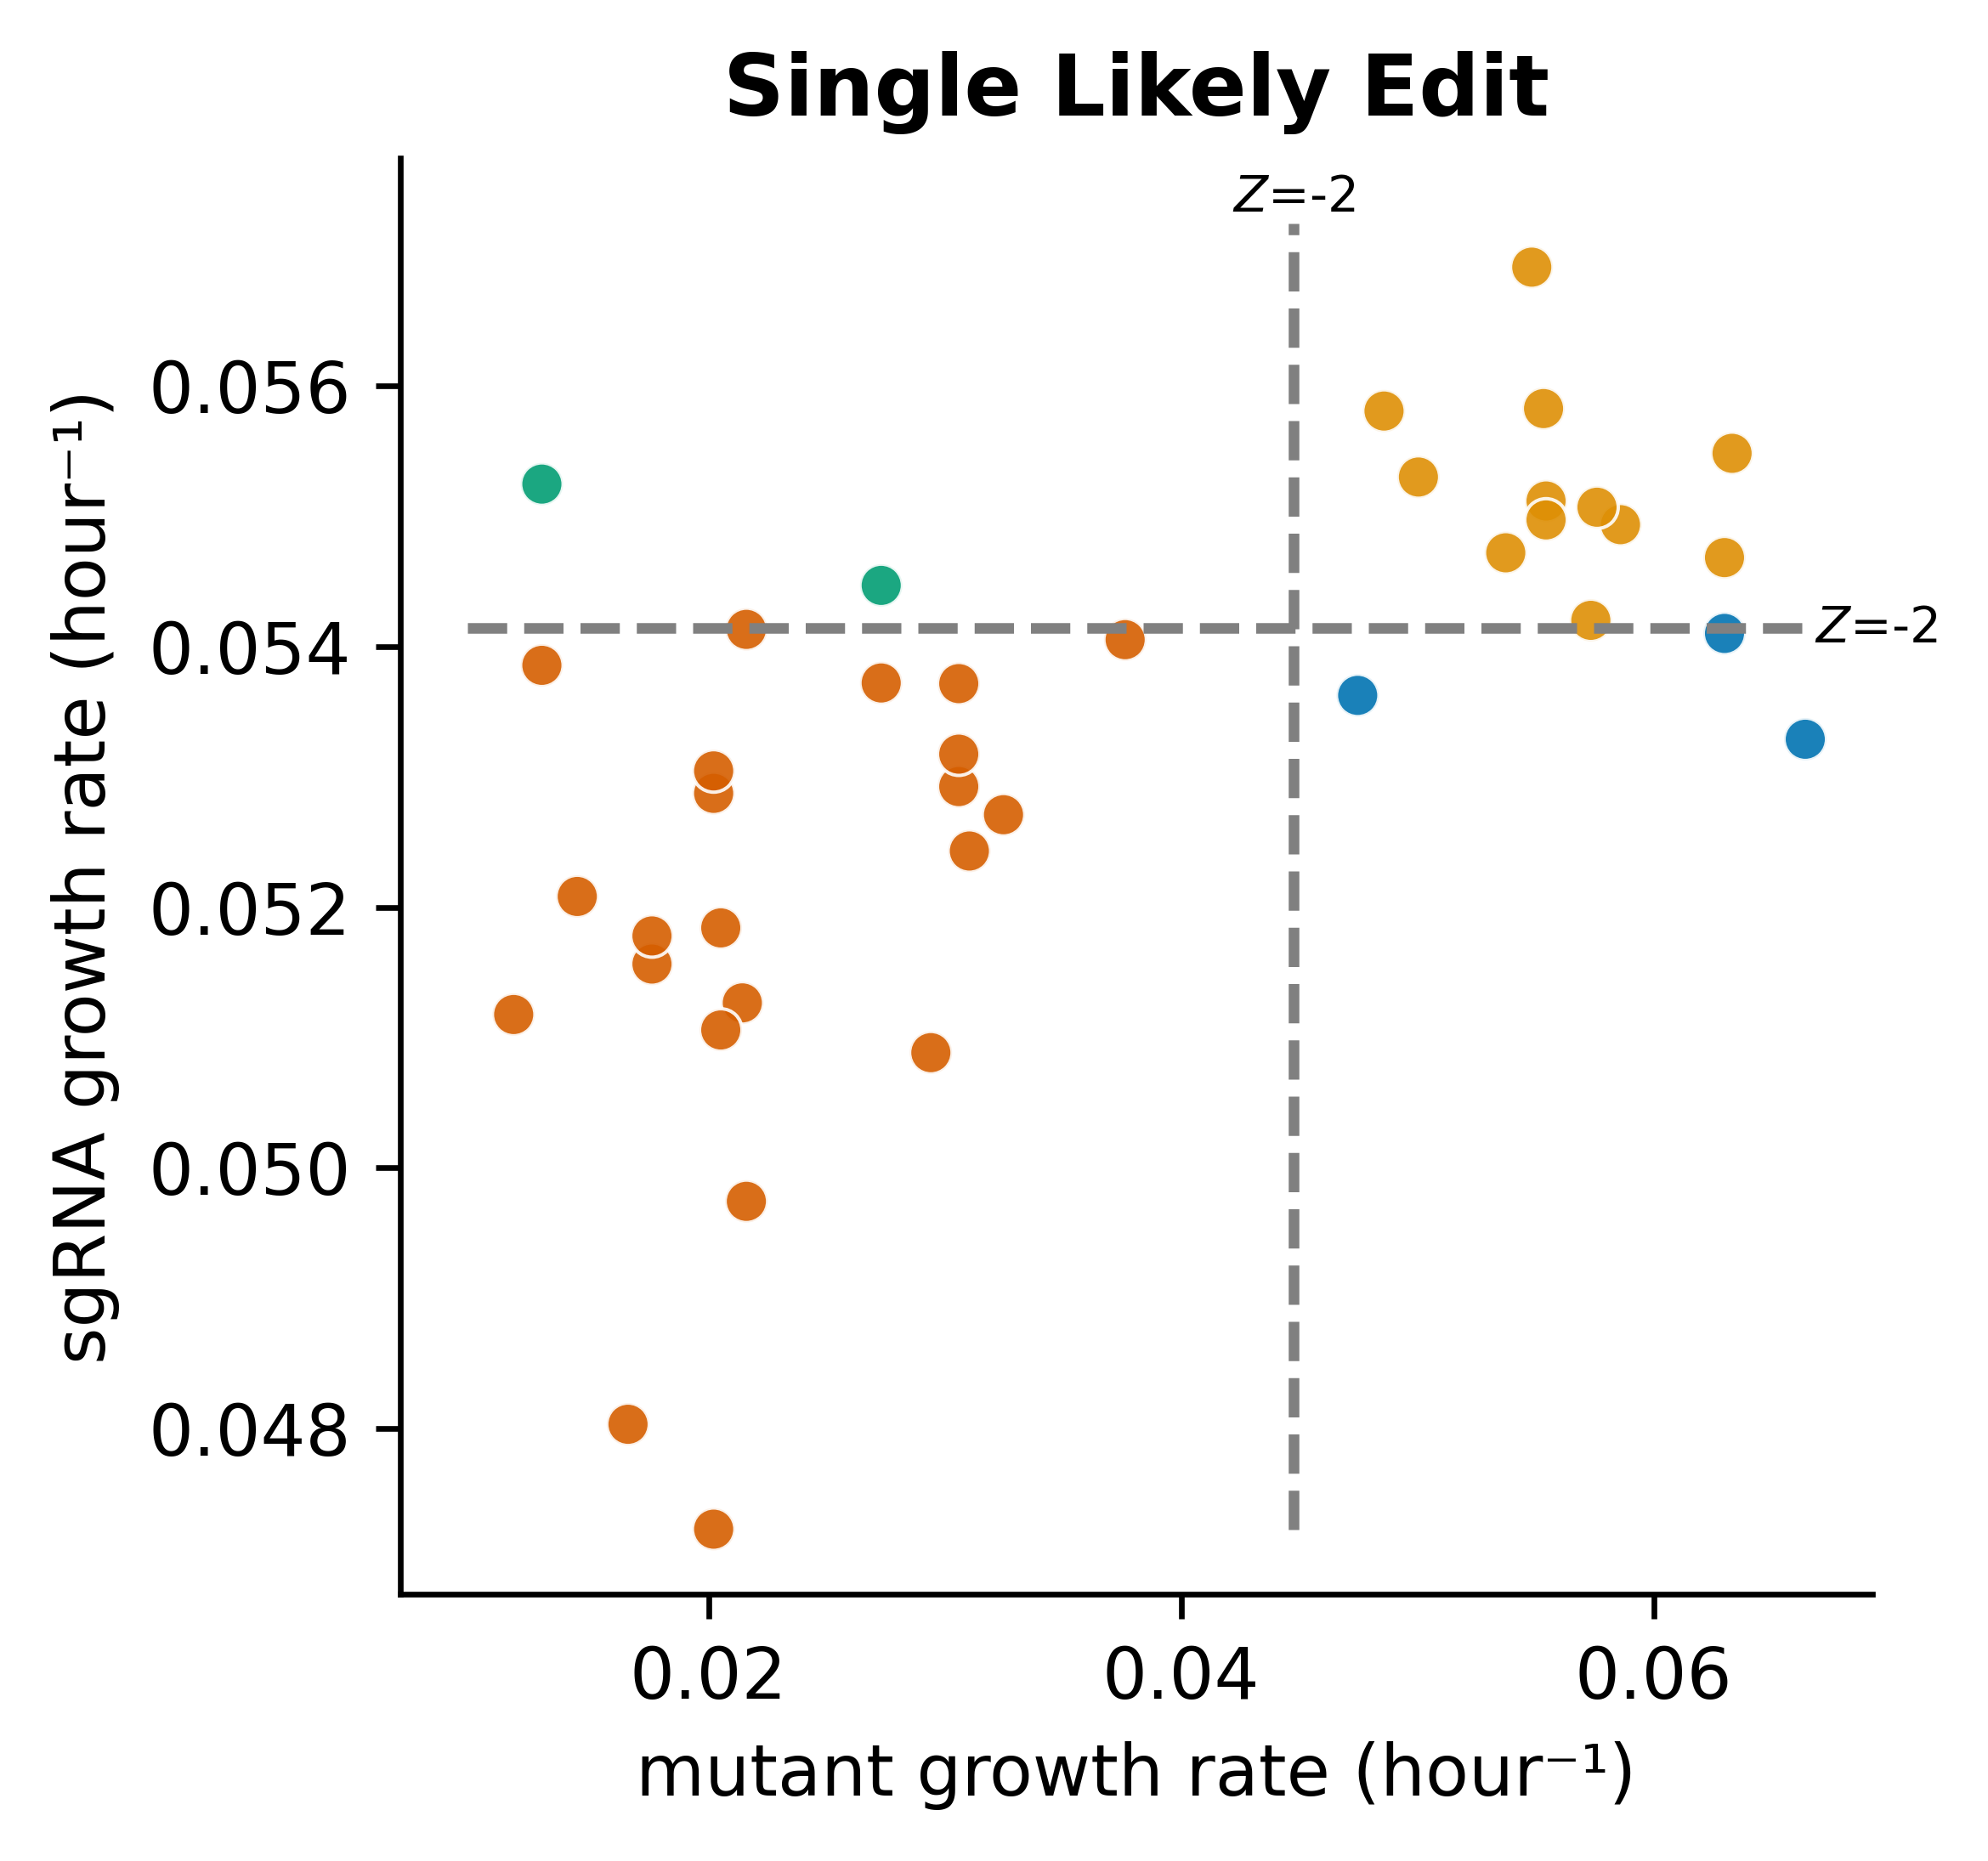

In [91]:
plt.figure(figsize=(4,3.75), dpi=600)
compare = sns.scatterplot(x='DMS_growthrate', y='ABE_growthrate',  hue='Agreement', legend=False,
                           palette=Agreement_Dict,alpha=0.9, data = ABE_DMS_Likely1)
compare.set(ylabel='sgRNA growth rate (hour⁻¹)', xlabel='mutant growth rate (hour⁻¹)')
plt.title('Single Likely Edit', fontdict={"weight": "bold"})
plt.hlines(ABE_2SD, ABE_DMS_match['DMS_growthrate'].min(), ABE_DMS_match['DMS_growthrate'].max(), linestyles="--", color='grey')
plt.vlines(DMS_2SD, ABE_DMS_match['ABE_growthrate'].min(), ABE_DMS_match['ABE_growthrate'].max(), linestyles="--", color='grey')
plt.text(DMS_2SD, ABE_DMS_match['ABE_growthrate'].max()+0.0002,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
plt.text(ABE_DMS_match['DMS_growthrate'].max()+0.003, ABE_2SD,'$\it{Z}$=-2', fontsize=7, ha='center', va='center')
sns.despine()
plt.tight_layout()
compare.get_figure().savefig("Naive_nuc4to8_Only1mut_Correlation250606.svg" , transparent=True) 

In [92]:
ABE_DMS_Likely1.loc[ABE_DMS_Likely1['sgName']=='BCRABL_1833']

,Unnamed: 0_x,sgRNA Seq,Strand,Location,PAM,Type,sgRNA_Nuc,Target_Nuc,AA_Number,Ref_Codon,...,DMS_Dropout,Agreement,color,Doench50,MIT,cfd,mm,mut_count,multi_mut,ANY_Dropout_DMS_mut
104,16818.0,GAGGTGGAAGAGTTCTTGAA,pos,3538.0,AGA,ABE,[8],[3545],1182.0,GAA,...,False,ABE,"(0.00392156862745098, 0.45098039215686275, 0.6...",True,False,True,True,1,False,False


In [93]:
ABE_DMS_Likely1.set_index(['sgName', 'mut'])[['DMS_growthrate', 'ABE_growthrate']].corr()

,DMS_growthrate,ABE_growthrate
DMS_growthrate,1.000000,0.640012
ABE_growthrate,0.640012,1.000000


In [94]:
pd.crosstab( ABE_DMS_Likely1['ABE_Dropout'], ABE_DMS_Likely1['DMS_Dropout'])

DMS_Dropout,False,True
ABE_Dropout,,
False,12,2
True,3,22


In [95]:
fisher_exact(pd.crosstab(ABE_DMS_Likely1['ABE_Dropout'], ABE_DMS_Likely1['DMS_Dropout']), alternative='greater')

SignificanceResult(statistic=44.0, pvalue=8.493152750445857e-06)

In [96]:
Hit_single_edit_sgRNA_count = ABE_DMS_Likely1.loc[(ABE_DMS_Likely1['ABE_Dropout']==True), 'sgName'].count()
TP_single_edit_sgRNA_count = ABE_DMS_Likely1.loc[(ABE_DMS_Likely1['ABE_Dropout']==True) & (ABE_DMS_Likely1['DMS_Dropout'] == True), 'mut'].count()
Hit_single_edit_sgRNA_count, TP_single_edit_sgRNA_count, (TP_single_edit_sgRNA_count/Hit_single_edit_sgRNA_count)

(25, 22, 0.88)

In [97]:
#Accuracy calculations
(22+12)/(12+2+3+22)

0.8717948717948718

In [98]:
ABE_DMS_Likely1.loc[(ABE_DMS_Likely1['ABE_Dropout']==True) & (ABE_DMS_Likely1['DMS_Dropout'] == True), 'mut'].count()

22

What are remaining pink dots?

In [99]:
ABE_DMS_Likely1.loc[ABE_DMS_Likely1['Agreement']=='ABE', ['sgName', 'sgRNA Seq', 'sgRNA_Nuc', 'mut', 'ABE_growthrate', 'DMS_growthrate']]

,sgName,sgRNA Seq,sgRNA_Nuc,mut,ABE_growthrate,DMS_growthrate
85,BCRABL_1823,TCCATGGTGTCCTCCTTCAA,[4],M278T,0.054100,0.062996
93,BCRABL_1826,GAAGGAGGACACCATGGAGG,[6],E275G,0.053625,0.047470
104,BCRABL_1833,GAGGTGGAAGAGTTCTTGAA,[8],E281G,0.053288,0.066415
